## Develop and test pyTMD harmonic fits with nodal corrections

1. Generate a 10 year prediction from FES
2. Fit with sfoda for first year only
3. Fit with pyTMD for first year only
4. Predict both for all years and compare results

In [4]:
import os
import glob
import numpy as np
import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt
# import nwatides as nwt
import timescale

fes_model = 'FES2022'
fes_dir = '/mnt/c/Users/00099894/Large_Data/Other/' + fes_model

In [5]:
import pyTMD
print(pyTMD.__version__)

2.2.7


In [6]:
seasonal_freq_list = ['M2','S2','K1','O1']
freq_list = ['N2','Q1']

constituents = seasonal_freq_list + freq_list
constituents_lower= [c.lower() for c in constituents]

lat, lon = -20, 114

In [7]:
default_fes_constituents = [
        "2n2",
        "eps2",
        "j1",
        "k1",
        "k2",
        "l2",
        "lambda2",
        "m2",
        "m3",
        "m4",
        "m6",
        "m8",
        "mf",
        "mks2",
        "mm",
        "mn4",
        "ms4",
        "msf",
        "msqm",
        "mtm",
        "mu2",
        "n2",
        "n4",
        "nu2",
        "o1",
        "p1",
        "q1",
        "r2",
        "s1",
        "s2",
        "s4",
        "sa",
        "ssa",
        "t2",
    ]

In [8]:
constits_tmd = pyTMD.arguments.frequency(default_fes_constituents)
constits_tmd

array([1.35240497e-04, 1.32954498e-04, 7.55603616e-05, 7.29211586e-05,
       1.45842317e-04, 1.43158106e-04, 1.42804901e-04, 1.40518903e-04,
       2.10778354e-04, 2.81037805e-04, 4.21556708e-04, 5.62075611e-04,
       5.32341440e-06, 1.40917115e-04, 2.63920305e-06, 2.78398602e-04,
       2.85963007e-04, 4.92520163e-06, 1.02486160e-05, 7.96261745e-06,
       1.35593701e-04, 1.37879700e-04, 2.75759399e-04, 1.38232904e-04,
       6.75977442e-05, 7.25229458e-05, 6.49585411e-05, 1.45643211e-04,
       7.27220522e-05, 1.45444104e-04, 2.90888209e-04, 1.99106385e-07,
       3.98212771e-07, 1.45244998e-04])

In [9]:
constis_float = np.array([1.405189e-04, 1.454441e-04, 1.378797e-04, 7.292116e-05, 6.759774e-05])

# Find where tmd constits equal float constits
matching_indices = [np.where(np.isclose(constits_tmd, cf, atol=1e-6))[0][0] for cf in constis_float]
matching_indices

[7, 4, 21, 3, 24]

In [10]:
print('Fitting constits:')
print([default_fes_constituents[i] for i in matching_indices])

Fitting constits:
['m2', 'k2', 'n2', 'k1', 'o1']


In [11]:
ssh_constits_str = [default_fes_constituents[i] for i in matching_indices]

# Repeat each entry n times
n = 7
ssh_constits_str_full = [item for item in ssh_constits_str for _ in range(n)]
ssh_constits_str_full

['m2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'm2',
 'k2',
 'k2',
 'k2',
 'k2',
 'k2',
 'k2',
 'k2',
 'n2',
 'n2',
 'n2',
 'n2',
 'n2',
 'n2',
 'n2',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'k1',
 'o1',
 'o1',
 'o1',
 'o1',
 'o1',
 'o1',
 'o1']

In [12]:
# ['M2','S2', 'N2', 'K1','O1']

In [13]:
x = np.array([3000,4000])
t = x.astype('timedelta64[s]') + np.datetime64('1990-01-01 00:00:00')

In [14]:
timescale.from_datetime(t).MJD

array([47892.03472222, 47892.0462963 ])

In [15]:
# Unzip the FES2022 XZ files
import lzma

def extract_xz_file(xz_filepath, output_filepath):
    """
    Decompresses a single .xz file.

    Args:
        xz_filepath (str): The path to the .xz file.
        output_filepath (str): The path where the decompressed content will be saved.
    """
    try:
        with lzma.open(xz_filepath, 'rb') as f_in:
            with open(output_filepath, 'wb') as f_out:
                f_out.write(f_in.read())
        print(f"Successfully extracted '{xz_filepath}' to '{output_filepath}'")
    except lzma.LZMAError as e:
        print(f"Error extracting XZ file: {e}")
    except FileNotFoundError:
        print(f"Error: File not found at '{xz_filepath}'")

xz_files = glob.glob(os.path.join(fes_dir, 'fes2022b', 'ocean_tide_20241025', '*.xz'))
matched_files = [f for f in xz_files if any(c.lower()+'_' in os.path.basename(f)[:3] for c in constituents)]
matched_files

['/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/q1_fes2022.nc.xz',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/s2_fes2022.nc.xz']

In [16]:
# Extract the files we need
# [extract_xz_file(file, file[:-3]) for file in xz_files]

In [17]:
model_files = glob.glob(os.path.join(fes_dir, 'fes2022b', 'ocean_tide_20241025', '*.nc'))
matched_files = [f for f in model_files if any(c+'_' in os.path.basename(f)[:3] for c in constituents_lower)]
matched_files

['/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/k1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/m2_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/n2_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/o1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/q1_fes2022.nc',
 '/mnt/c/Users/00099894/Large_Data/Other/FES2022/fes2022b/ocean_tide_20241025/s2_fes2022.nc']

In [18]:
# Get the constituent amp and phase 
amp, ph = pyTMD.io.FES.extract_constants(
    np.atleast_1d(lon), 
    np.atleast_1d(lat),
    matched_files,
    type="z",
    version=fes_model,
    method="bilinear",
    scale=1/100)

In [19]:
# Test the nodal correction func for a random date
pu, pf, G = pyTMD.arguments.arguments(52622, constituents=constituents_lower, corrections="FES")

In [20]:
# Create the test and train data
delta_time = np.arange(365*24)*timescale.time._to_sec['hour']
ts = timescale.from_deltatime(delta_time, epoch=(2013,7,1,0,0,0))
DELTAT = ts.tt_ut1
ts.to_datetime()[0:3]

array(['2013-07-01T00:00:00.000000000', '2013-07-01T01:00:00.000000000',
       '2013-07-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [21]:
# calculate complex phase in radians for Euler's
cph = -1j*ph*np.pi/180.0
# calculate constituent oscillation
hc = amp*np.exp(cph)

In [22]:
# predict tidal elevations at time and infer minor corrections
TIDE = pyTMD.predict.time_series(ts.MJD, hc, constituents_lower,
                                corrections='FES')
MINOR = pyTMD.predict.infer_minor(ts.MJD, hc, constituents_lower,
                                deltat=DELTAT, corrections='FES')
TIDE.data[:] += MINOR.data[:]

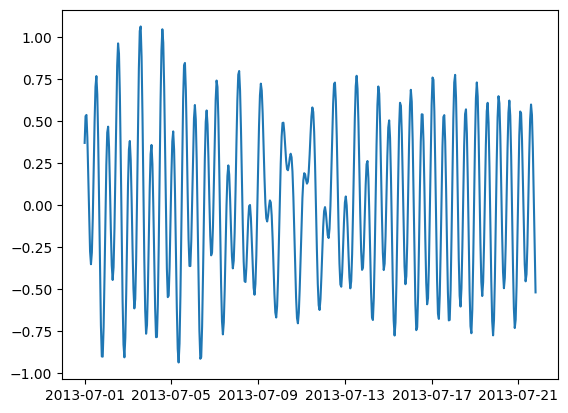

In [23]:
px = 500

plt.plot(ts.to_datetime()[:px], TIDE.data[:px], label='FES2022')

# Fit with tidal constituents vs. without

In [24]:
amp_tmd, ph_tmd = pyTMD.solve.constants(ts.MJD, TIDE.data, constituents=constituents_lower)

cph_tmd = -1j*ph_tmd*np.pi/180.0
# calculate constituent oscillation
hc_tmd = amp_tmd*np.exp(cph_tmd)

In [25]:
TIDE_tmd = pyTMD.predict.time_series(ts.MJD, hc_tmd, constituents_lower,
                                corrections='FES')
MINOR_tmd = pyTMD.predict.infer_minor(ts.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT, corrections='FES')
TIDE_tmd.data[:] += MINOR_tmd.data[:]

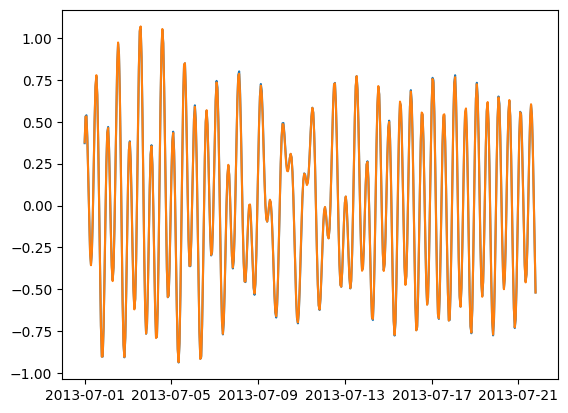

In [26]:
plt.plot(ts.to_datetime()[:px], TIDE.data[:px], label='FES2022')
plt.plot(ts.to_datetime()[:px], TIDE_tmd.data[:px], label='TMD (FES)')

## Generate test 9 years later and use original fits to predict

In [27]:
ts_test = timescale.from_deltatime(delta_time, epoch=(2022,7,1,0,0,0))
DELTAT_test = ts_test.tt_ut1
ts_test.to_datetime()[0:3]

array(['2022-07-01T00:00:00.000000000', '2022-07-01T01:00:00.000000000',
       '2022-07-01T02:00:00.000000000'], dtype='datetime64[ns]')

In [28]:
# predict tidal elevations at time and infer minor corrections
TIDE_test = pyTMD.predict.time_series(ts_test.MJD, hc_tmd, constituents_lower,
                                corrections='FES')
MINOR_test = pyTMD.predict.infer_minor(ts_test.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT_test, corrections='FES')
TIDE_test.data[:] += MINOR_test.data[:]

In [29]:
TIDE_tmd_test = pyTMD.predict.time_series(ts_test.MJD, hc_tmd, constituents_lower,
                                corrections=None)
MINOR_tmd_test = pyTMD.predict.infer_minor(ts_test.MJD, hc_tmd, constituents_lower,
                                deltat=DELTAT_test, corrections=None)
TIDE_tmd_test.data[:] += MINOR_tmd_test.data[:]

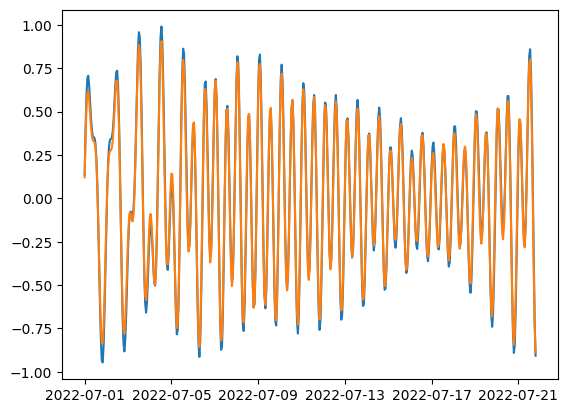

In [30]:
plt.plot(ts_test.to_datetime()[:px], TIDE_test.data[:px], label='FES2022')
plt.plot(ts_test.to_datetime()[:px], TIDE_tmd_test.data[:px], label='FES2022_fit')

In [31]:
# from ichthys_harmonics.harmonic_lstsq import harmonic_fit, least_squares_prediction

# # Fit with tidal constituents vs. without
# ds_pred = harmonic_fit(ts.to_datetime(), TIDE.data, constituents='iwatlas_constits')

In [32]:
delta_time = np.arange(365*18.6)*timescale.time._to_sec['day']
ts = timescale.from_deltatime(delta_time, epoch=(2013,7,1,0,0,0))

In [33]:
pu, pf, G = pyTMD.arguments.arguments(ts.MJD, constituents=constituents_lower, corrections="FES")

In [34]:
ts_mean = timescale.from_deltatime(np.arange(1)*timescale.time._to_sec['day'], epoch=(2014,1,1,0,0,0))
ts_mean.MJD

array([56658.])

In [35]:
constituents_lower

['m2', 's2', 'k1', 'o1', 'n2', 'q1']

[[<matplotlib.lines.Line2D at 0x7bedaa8e3050>],

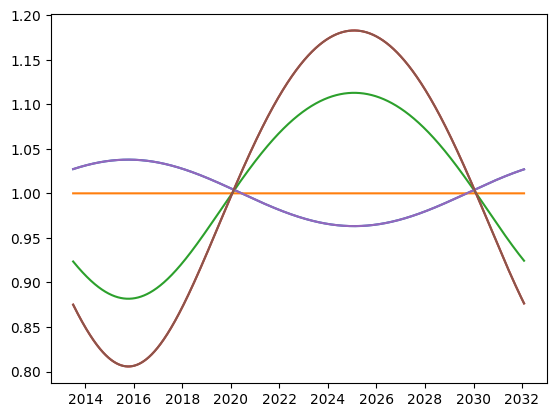

In [36]:
[plt.plot(ts.to_datetime(), pf[:,i], label=constituents_lower[i]) for i in range(len(constituents_lower))]

[[<matplotlib.lines.Line2D at 0x7bedaa7618e0>],

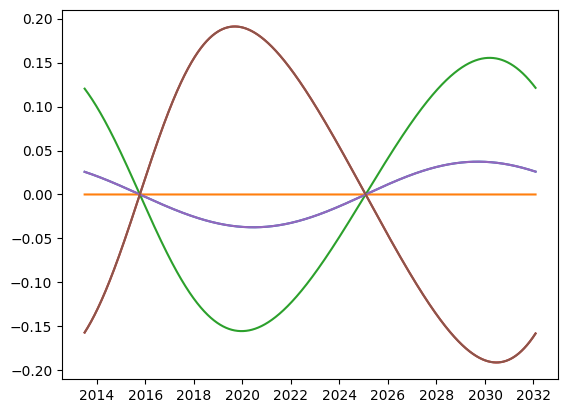

In [37]:
[plt.plot(ts.to_datetime(), pu[:,i], label=constituents_lower[i]) for i in range(len(constituents_lower))]

In [38]:
# hc, c = nwt.fes.load_tidal_amplitudes_np(np.atleast_1d(lon), np.atleast_1d(lat), "z",
#                                           constituents=constituents[:2], fes_dir=os.path.join(fes_dir,'fes2022b'))
# hc

In [39]:
# ha = nwt.fes.load_tidal_amplitudes(np.atleast_1d(lon), np.atleast_1d(lat), "z",
#                                    constituents=[constituents_lower[0]], fes_dir=os.path.join(fes_dir,'fes2022b'))


In [40]:
# model = pyTMD.io.model(fes_dir, constituents=constituents_lower, type='z', version=fes_model,\
#                         crop=True, bounds=[[lon-1, lon+1],[lat-1,lat+1]]).elevation(fes_model)

In [41]:
# tmd_consts = pyTMD.io.FES.read_constants(model.model_file,
#                                             type=model.type, version=model.version,
#                                             compressed=model.compressed)
# tmd_consts

In [42]:
# amp,ph = pyTMD.io.FES.interpolate_constants(
#                     np.atleast_1d(lon), np.atleast_1d(lat),
#                     constituents, scale=model.scale,
#                     method='spline', extrapolate=True)